# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook aims to create submissions to the Bike Sharing Demand competition using AutoGluon.

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle

     |████████████████████████████████| 2.1 MB 25.4 MB/s            
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 163.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 178.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 135.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080019 sha256=cdda87c9bbec1ef89e68b1648a04a5a2397cd2c1ca697dc7aacf4f786bc60480
  Stored in directory: /tmp/pip-ephem-wheel-cache-nr9w3m6b/wheels/9f/9e/ac/f24f30e119df

### Download and explore dataset

In [7]:
# Download the dataset
!kaggle competitions download -c bike-sharing-demand
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 2.69MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.

In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [8]:
train = train.drop(['casual', 'registered'], axis=1)

In [18]:
predictor = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error').fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230330_184728/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230330_184728/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Mar 14 23:44:59 UTC 2023
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2494.73 MB
	Train Data (Original)  Memory Usage: 1.52 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

### Review AutoGluon's training run with ranking of models that did the best.

In [19]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.067211      14.975821  552.409811                0.002035           0.322671            3       True         14
1   RandomForestMSE_BAG_L2  -53.376541      10.932367  410.251386                0.599237          26.610942            2       True         12
2          LightGBM_BAG_L2  -55.140094      10.741092  407.739855                0.407963          24.099410            2       True         11
3          CatBoost_BAG_L2  -55.734854      10.385696  448.771620                0.052567          65.131176            2       True         13
4        LightGBMXT_BAG_L2  -60.318974      13.914018  436.245612                3.580889          52.605168            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.103544    0.029993         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

### Create predictions from test dataset

In [21]:
predictions = predictor.predict(test)
predictions.head()

0    23.319860
1    41.932030
2    45.338593
3    49.514996
4    52.013477
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [22]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.620903
std        89.865044
min         3.134735
25%        20.021202
50%        64.498055
75%       167.204422
max       367.269745
Name: count, dtype: float64

### Set predictions to submission dataframe, save, and submit

In [27]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [28]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 218kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [29]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2023-03-30 19:09:43  first raw submission  complete  1.79648      1.79648       


#### Initial score of 1.79648

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

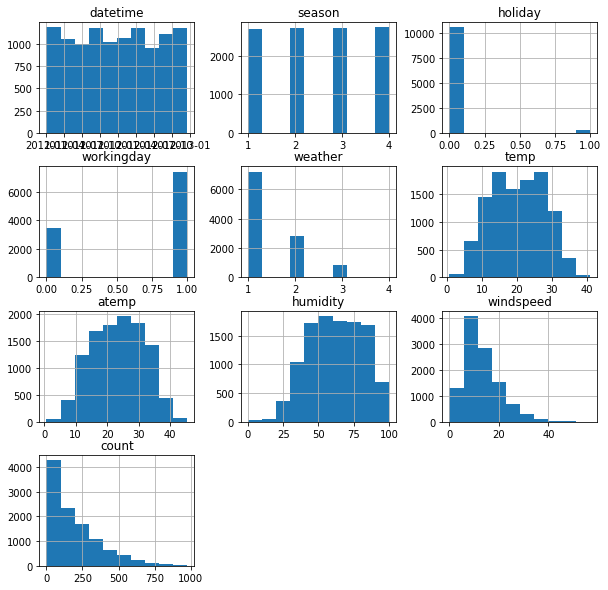

In [11]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(10, 10))
plt.show()

In [12]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month

test['hour'] = test['datetime'].dt.hour
test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [13]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
train = train.drop(['datetime'], axis=1)

test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')
test = test.drop(['datetime'], axis=1)

In [14]:
# View new features
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1
3,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1
4,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1


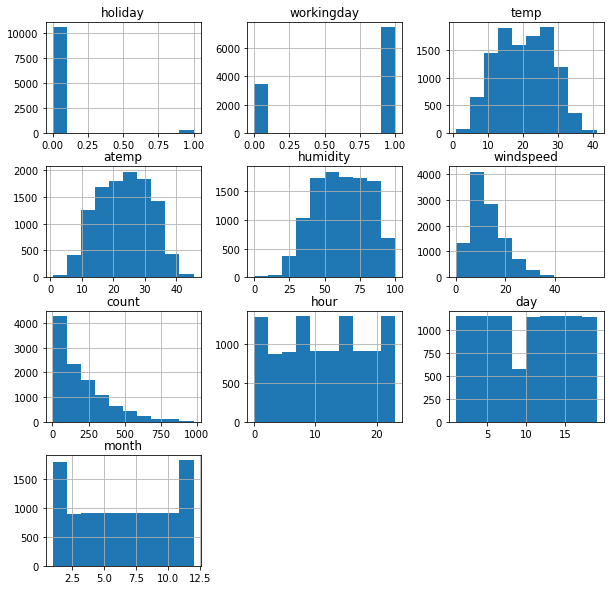

In [15]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(10, 10))
plt.show()

## Step 5: Rerun the model with the same settings as before, just with more features

In [36]:
predictor_new_features = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error').fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230412_115423/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230412_115423/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Mar 23 09:54:12 UTC 2023
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2933.75 MB
	Train Data (Original)  Memory Usage: 0.81 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note

In [37]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -49.926871      54.789600  489.107680                0.000804           0.401796            3       True         16
1          CatBoost_BAG_L2  -50.259294      53.564627  454.845500                0.086934          67.962306            2       True         13
2     ExtraTreesMSE_BAG_L2  -50.366740      54.093841  394.546409                0.616148           7.663215            2       True         14
3          LightGBM_BAG_L2  -50.890489      53.597920  408.333056                0.120227          21.449861            2       True         11
4   RandomForestMSE_BAG_L2  -50.994317      54.085713  413.080364                0.608021          26.197169            2       True         12
5      WeightedEnsemble_L2  -51.385375      52.080058  349.697774         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.93326033133259,
  'KNeighborsDist_BAG_L1': -119.3656013058328

In [38]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    29.739716
1     6.066018
2     5.472265
3     3.955956
4     4.027080
Name: count, dtype: float32

In [40]:
# Number of zero predictions
predictions_new_features[predictions_new_features < 0].sum()

0.0

In [43]:
# Same submitting predictions
submission_new_features = submission.copy()
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [44]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "datetime features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 236kB/s]
Successfully submitted to Bike Sharing Demand

In [45]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2023-04-12 12:09:56  datetime features     complete  0.53646      0.53646       
submission_new_features.csv  2023-03-30 19:48:32  new features          complete  1.79648      1.79648       
submission.csv               2023-03-30 19:09:43  first raw submission  complete  1.79648      1.79648       


#### New Score of 0.53646

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization. Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* Here it was decided to change the num_stack_levels to 3, num_bag_folds to 10 and num_bag_sets to 20.

In [ ]:
predictor_new_hpo = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error').fit(train_data=train, time_limit=600, presets="best_quality", num_bag_folds=10, num_bag_sets=20, num_stack_levels=3)

No path specified. Models will be saved in: "AutogluonModels/ag-20230412_173258/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=10, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230412_173258/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Mar 23 09:54:12 UTC 2023
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2137.33 MB
	Train Data (Original)  Memory Usage: 0.81 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Not

In [36]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.760430      55.299415  362.287797                0.001405           0.528016            3       True         12
1          CatBoost_BAG_L2  -50.878382      53.243144  267.503601                0.126419          51.677433            2       True          9
2      WeightedEnsemble_L4  -50.970759      56.510001  475.553380                0.001040           0.307734            4       True         17
3          CatBoost_BAG_L3  -51.079427      55.749913  423.214424                0.109471          32.261086            3       True         16
4      WeightedEnsemble_L2  -51.173405      52.709923  216.069363                0.000917           0.291543            2       True          5
5          LightGBM_BAG_L2  -51.527480      53.251653  242.315629         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L3': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L3': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L3': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L4': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L4': 'StackerEnsemb

In [37]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    46.371834
1     7.241138
2     5.142256
3     3.773198
4     4.159402
Name: count, dtype: float32

In [38]:
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [39]:
# Same submitting predictions
submission_new_hpo = submission.copy()
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [40]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameter 2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 241kB/s]
Successfully submitted to Bike Sharing Demand

In [41]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                         status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-04-12 17:47:04  new features with hyperparameter 2  complete  0.59752      0.59752       
submission_new_hpo.csv       2023-04-12 17:12:38  new features with hyperparameter    complete  0.56212      0.56212       
submission_new_features.csv  2023-04-12 12:09:56  datetime features                   complete  0.53646      0.53646       
submission_new_features.csv  2023-03-30 19:48:32  new features                        complete  1.79648      1.79648       


#### New Score of `0.59752`

### Tuning hyperparameters of specific models

In [9]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 10*60  # train various models for ~10 min
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [11]:
predictor_new_hpo_specific_models = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error').fit(train_data=train, time_limit=600, presets="best_quality", hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L2... Skipping this model.
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 184.51s of remaining time.
	-132.681	 = Validation score   (-root_mean_squared_error)
	0.78s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 416.52s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230413_195831/")


In [12]:
predictor_new_hpo_specific_models.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3 -132.681009       0.527204  278.897817                0.001359           0.779573            3       True         12
1    LightGBM_BAG_L2/T2 -132.908817       0.525569  232.223060                0.000102          22.244213            2       True          8
2    LightGBM_BAG_L2/T1 -133.078436       0.525605  232.463637                0.000138          22.484789            2       True          7
3    LightGBM_BAG_L2/T5 -133.197303       0.525604  233.050502                0.000136          23.071655            2       True         11
4    LightGBM_BAG_L2/T3 -133.265759       0.525605  233.389241                0.000138          23.410393            2       True          9
5   WeightedEnsemble_L2 -133.677097       0.228070   83.312544                0.001261      

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T5': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -134.9455441317704,
  'LightGBM_BAG_L1/T2': -134.60298148868924,
  'LightGBM_BAG_L1/T3': -133.70973886194457,
  'LightGBM_BAG_L1/T4': -155.91595677865007,
  'LightGBM_BAG_L1/T5': -135.31680769607678,
  'WeightedEnsemble_L2': -133.6770966051146,
  'LightGBM_BAG_L2/T1': -133.07843572359974,
  'LightGBM_BAG_L2/T2': -132.

In [13]:
predictions_new_hpo_specific_models = predictor_new_hpo_specific_models.predict(test)
predictions_new_hpo_specific_models.head()

0    74.560242
1    52.362000
2    52.362000
3    65.706917
4    65.706917
Name: count, dtype: float32

In [16]:
predictions_new_hpo_specific_models[predictions_new_hpo_specific_models < 0] = 0

In [17]:
# Same submitting predictions
submission_new_hpo_specific_models = submission.copy()
submission_new_hpo_specific_models["count"] = predictions_new_hpo_specific_models
submission_new_hpo_specific_models.to_csv("submission_new_hpo_specific_models.csv", index=False)

In [18]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_specific_models.csv -m "new features with hyperparameter optimization of specific models"

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 217kB/s]
Successfully submitted to Bike Sharing Demand

In [19]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                date                 description                                                       status    publicScore  privateScore  
--------------------------------------  -------------------  ----------------------------------------------------------------  --------  -----------  ------------  
submission_new_hpo_specific_models.csv  2023-04-13 20:10:23  new features with hyperparameter optimization of specific models  complete  1.31462      1.31462       
submission_new_hpo.csv                  2023-04-12 17:47:04  new features with hyperparameter 2                                complete  0.59752      0.59752       
submission_new_hpo.csv                  2023-04-12 17:12:38  new features with hyperparameter                                  complete  0.56212      0.56212       
submission_new_features.csv             2023-04-12 12:09:56  datetime features                                                 complete  0.53646      0.53646       


## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

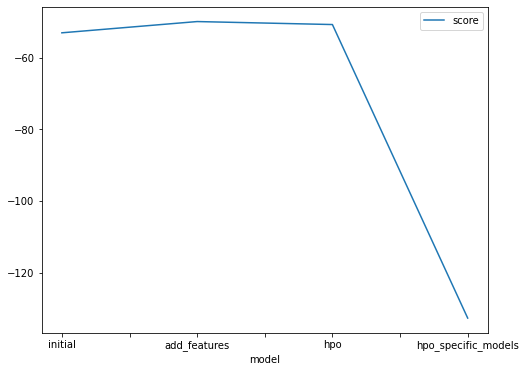

In [20]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "hpo_specific_models"],
        "score": [-53.067211, -49.926871, -50.760430, -132.681009]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

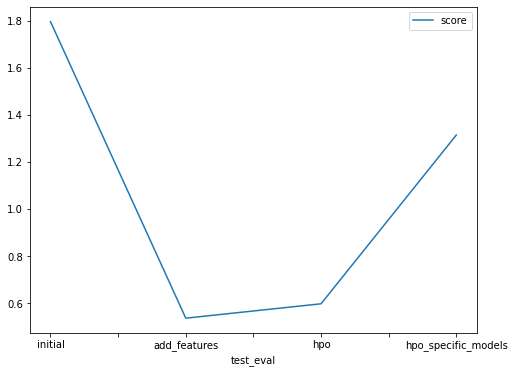

In [21]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo", "hpo_specific_models"],
        "score": [1.79648, 0.53646, 0.59752, 1.31462]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [44]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "num_bag_folds": [8, 8, 10],
    "num_bag_sets": [20, 20, 20],
    "num_stack_levels": [1, 1, 3],
    "score": [1.79648, 0.53646, 0.59752]
})

,model,num_bag_folds,num_bag_sets,num_stack_levels,score
0,initial,8,20,1,1.79648
1,add_features,8,20,1,0.53646
2,hpo,10,20,3,0.59752
